<a href="https://colab.research.google.com/github/Diana-codes/Advanced-Linear-algebra/blob/main/Summative_Intro_to_ml_Diana_Ruzindana_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CropSense AI: Crop Disease Detection in Rwanda

Objective: This notebook explores classification models for plant disease detection using classical ML and neural networks, applying optimization techniques to improve performance.

A Notebook detailing the following

* Project name





**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



Step 1: Setup and Install Dependencies

In [ ]:
!pip install tensorflow tensorflow-datasets seaborn joblib


Step 2: Imports & Global Setup

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from joblib import dump

# SECTION 1: Model Architecture


<img src="model_architecture.png" alt="CNN Model Architecture - CropSense AI" style="width:400px"/>


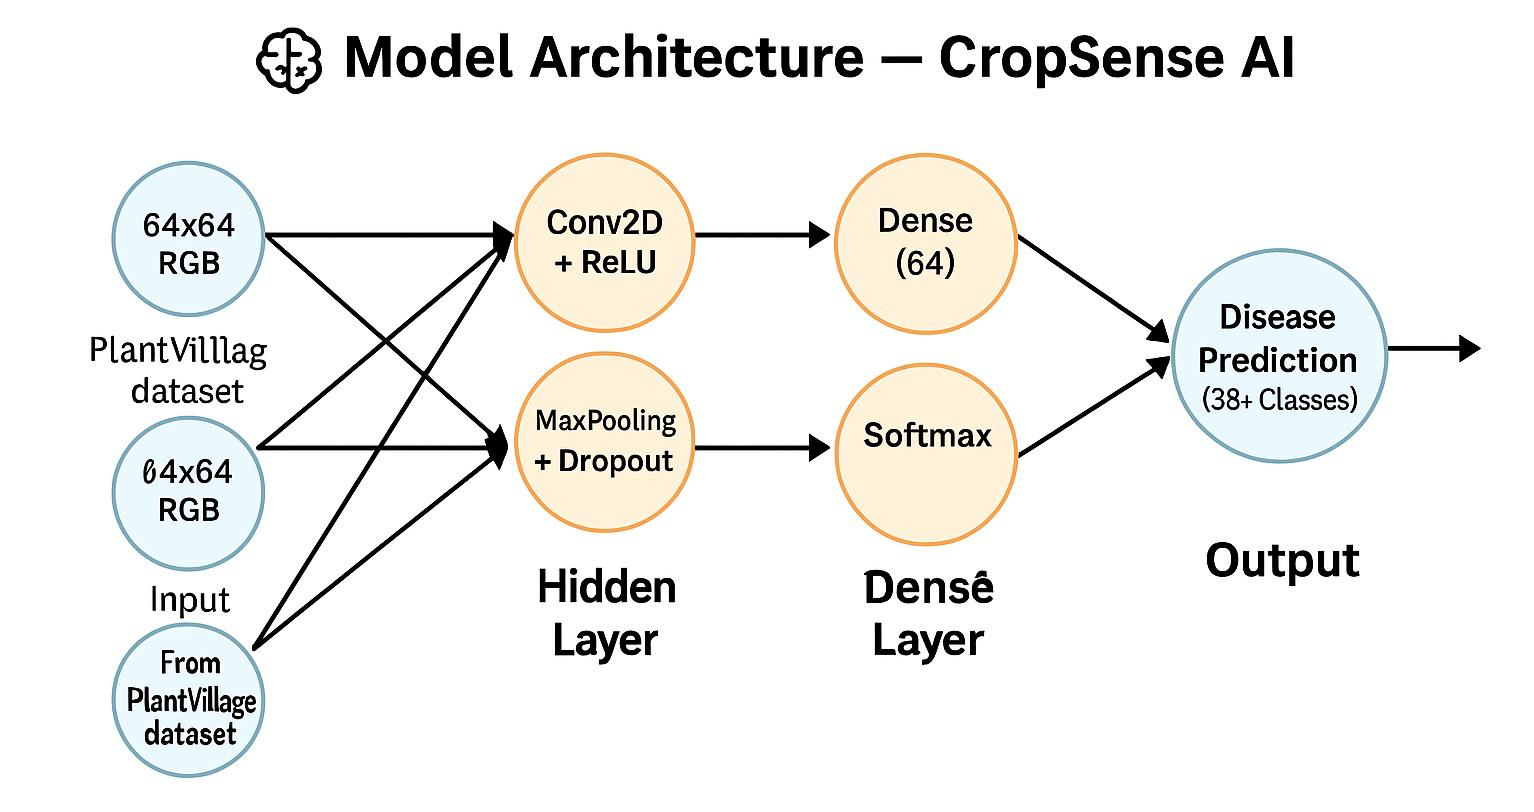

In [6]:
from IPython.display import Image, display
display(Image("model_architecture.png", width=400))

Step 3: Load PlantVillage Dataset



In [ ]:
# Load PlantVillage from TFDS
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Resize, normalize, and batch
IMG_SIZE = 64
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(1)

# Check class names
class_names = ds_info.features['label'].names
print("Detected classes:", class_names)
NUM_CLASSES = len(class_names)

Detected classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_

Step 4: Define define_model() Function

In [ ]:
def define_model(optimizer='adam', regularizer=None, early_stopping=False, dropout_rate=0.3, lr=0.001, layers_num=2):
    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    for _ in range(layers_num):
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    opt = tf.keras.optimizers.get(optimizer)
    opt.learning_rate = lr

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    return model, callbacks

Instance 1: Baseline Model (No Optimization)

In [ ]:
# Instance 1: Baseline model (no optimizer tuning, no early stopping, default settings)

model_1, callbacks_1 = define_model(
    optimizer='adam',          # default
    regularizer=None,          # no regularizer
    early_stopping=False,      # no early stopping
    dropout_rate=0.0,          # no dropout
    lr=0.001,                  # default learning rate
    layers_num=2               # 2 conv layers
)

history_1 = model_1.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_1,
    verbose=1
)

# Save model
os.makedirs("saved_models", exist_ok=True)
model_1.save("saved_models/model_instance_1.keras")


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 313s 226ms/step - accuracy: 0.4980 - loss: 1.8654 - val_accuracy: 0.7948 - val_loss: 0.6757
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 308s 226ms/step - accuracy: 0.8047 - loss: 0.6377 - val_accuracy: 0.8316 - val_loss: 0.5310
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 321s 225ms/step - accuracy: 0.8572 - loss: 0.4532 - val_accuracy: 0.8683 - val_loss: 0.4280
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 283s 208ms/step - accuracy: 0.8844 - loss: 0.3570 - val_accuracy: 0.8747 - val_loss: 0.4125
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 339s 220ms/step - accuracy: 0.9066 - loss: 0.2906 - val_accuracy: 0.8813 - val_loss: 0.4037
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 321s 220ms/step - accuracy: 0.9256 - loss: 0.2324 - val_accuracy: 0.8939 - val_loss: 0.3457
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 299s 220ms/step - accuracy: 0.9382 - loss: 0.1866 - val_accuracy: 0.9005 - val_loss: 0.3385
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 300s 220ms/step - ac

Evaluate & Visualize

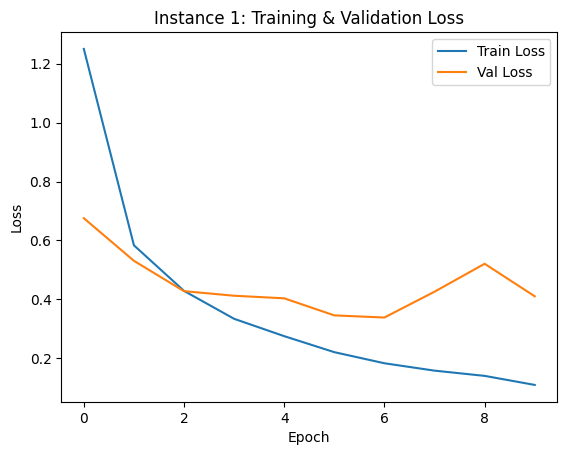

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

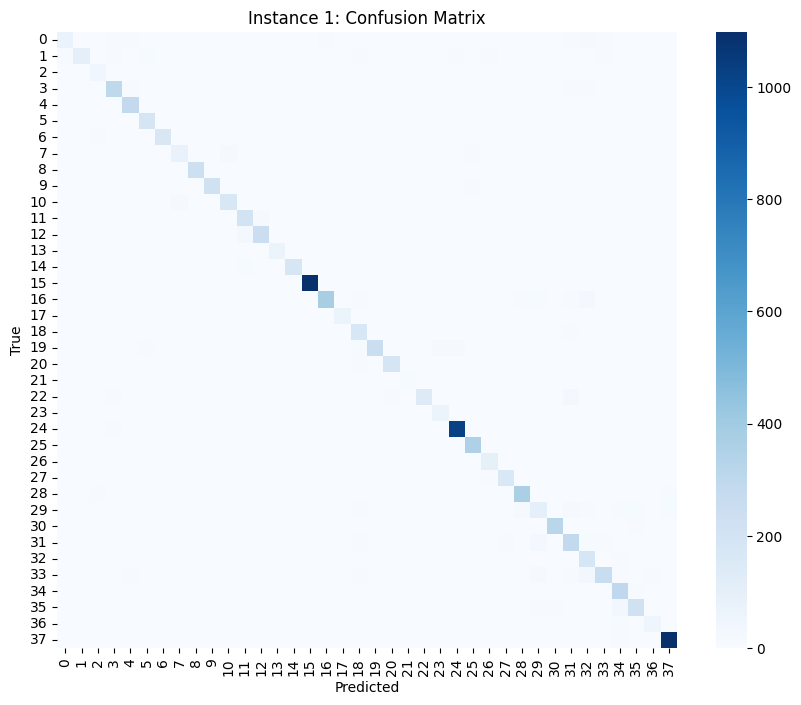

In [ ]:
# Plot loss curve
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.title("Instance 1: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate model on validation set
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_1.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 1 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Instance 1: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 2: RMSprop + L2 Regularization + Dropout + Early Stopping

In [ ]:
l2_reg = regularizers.l2(0.01)

model_2, callbacks_2 = define_model(
    optimizer='rmsprop',
    regularizer=l2_reg,
    early_stopping=True,
    dropout_rate=0.3,
    lr=0.0005,
    layers_num=3
)

history_2 = model_2.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=callbacks_2,
    verbose=1
)

# Save model
model_2.save("saved_models/model_instance_2.keras")

Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 341s 246ms/step - accuracy: 0.2544 - loss: 3.1456 - val_accuracy: 0.5647 - val_loss: 1.7205
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 355s 261ms/step - accuracy: 0.5510 - loss: 1.7400 - val_accuracy: 0.6657 - val_loss: 1.3410
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 325s 238ms/step - accuracy: 0.6412 - loss: 1.3754 - val_accuracy: 0.7318 - val_loss: 1.0822
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 323s 237ms/step - accuracy: 0.6953 - loss: 1.1610 - val_accuracy: 0.7372 - val_loss: 1.0137
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 324s 237ms/step - accuracy: 0.7323 - loss: 1.0447 - val_accuracy: 0.7663 - val_loss: 0.9264
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 388s 242ms/step - accuracy: 0.7574 - loss: 0.9531 - val_accuracy: 0.7982 - val_loss: 0.8162
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 393s 251ms/step - accuracy: 0.7730 - loss: 0.8932 - val_accuracy: 0.8063 - val_loss: 0.7854
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 357s 262ms/step - ac

Evaluation Cell

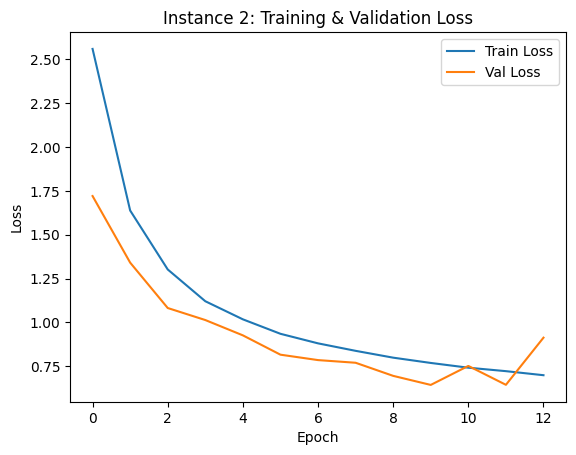

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107

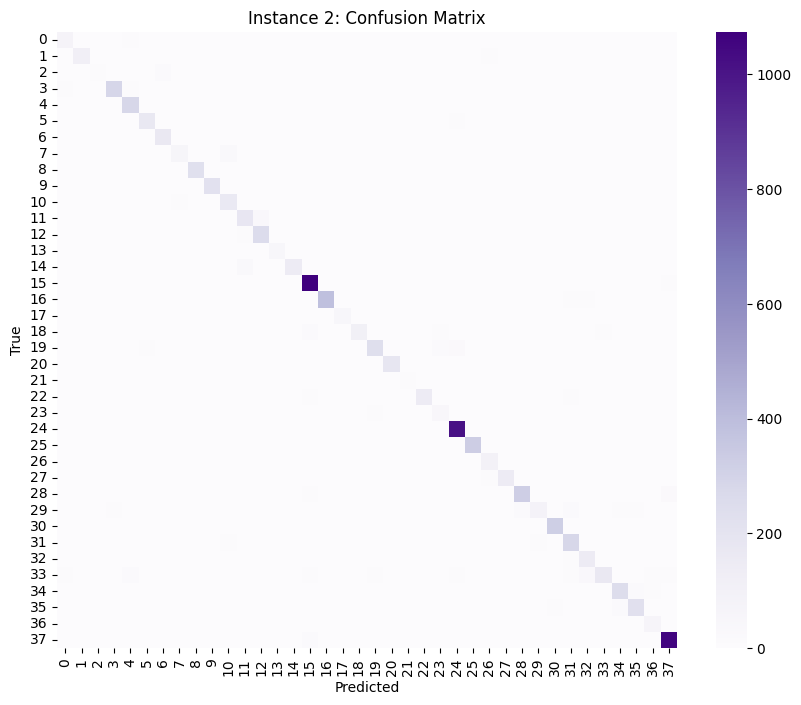

In [ ]:
# Plot loss curve
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.title("Instance 2: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_2.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 2 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Purples')
plt.title("Instance 2: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 3: Adam + L1 Regularization + Dropout + More Layers

In [ ]:
l1_reg = regularizers.l1(0.01)

model_3, callbacks_3 = define_model(
    optimizer='adam',
    regularizer=l1_reg,
    early_stopping=True,
    dropout_rate=0.4,
    lr=0.0003,
    layers_num=4
)

history_3 = model_3.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,  # Reduced from 15 to 10
    callbacks=callbacks_3,
    verbose=1
)

model_3.save("saved_models/model_instance_3.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 353s 255ms/step - accuracy: 0.0936 - loss: 8.0328 - val_accuracy: 0.1020 - val_loss: 3.3685
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 327s 240ms/step - accuracy: 0.0991 - loss: 3.3736 - val_accuracy: 0.1020 - val_loss: 3.3497
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 345s 253ms/step - accuracy: 0.0990 - loss: 3.3615 - val_accuracy: 0.1020 - val_loss: 3.3497
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 327s 240ms/step - accuracy: 0.0987 - loss: 3.3631 - val_accuracy: 0.1020 - val_loss: 3.3500
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 344s 253ms/step - accuracy: 0.1009 - loss: 3.3615 - val_accuracy: 0.1020 - val_loss: 3.3496
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 345s 254ms/step - accuracy: 0.0998 - loss: 3.3617 - val_accuracy: 0.1020 - val_loss: 3.3498
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 327s 240ms/step - accuracy: 0.0992 - loss: 3.3621 - val_accuracy: 0.1020 - val_loss: 3.3498
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 401s 254ms/step - ac

 Evaluation Cell

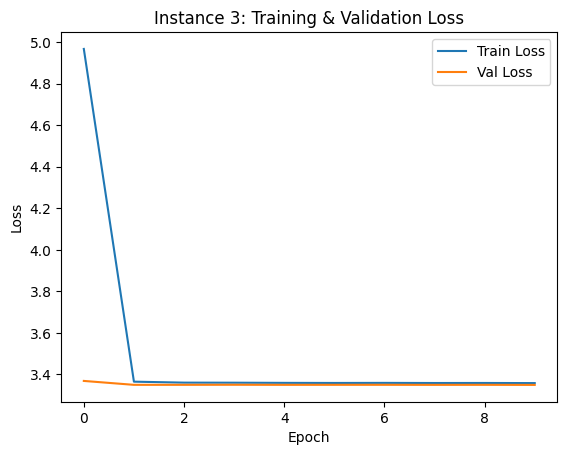

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Instance 3 Metrics:
Accuracy: 0.1020
Precision: 0.0027
Recall: 0.0263
F1-score: 0.0049


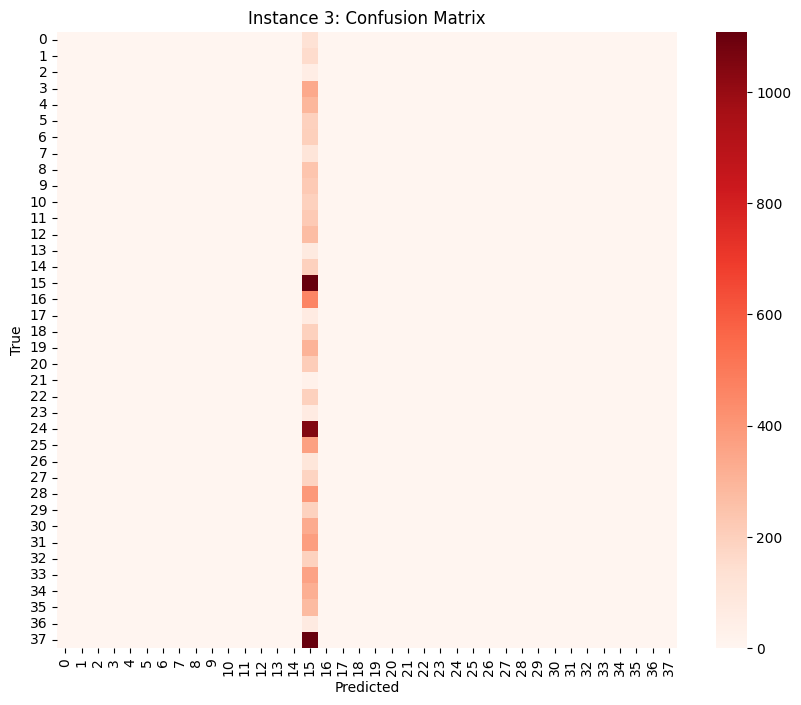

In [ ]:
# Plot loss curve
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.title("Instance 3: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_3.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 3 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Reds')
plt.title("Instance 3: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 4: RMSprop + L1_L2 Combo + NO EarlyStopping

In [ ]:
l1_l2_reg = regularizers.l1_l2(l1=0.005, l2=0.005)

model_4, callbacks_4 = define_model(
    optimizer='rmsprop',
    regularizer=l1_l2_reg,
    early_stopping=False,         # No EarlyStopping
    dropout_rate=0.2,
    lr=0.0007,
    layers_num=3
)

history_4 = model_4.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_4,
    verbose=1
)

model_4.save("saved_models/model_instance_4.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 317s 231ms/step - accuracy: 0.1647 - loss: 4.0935 - val_accuracy: 0.4041 - val_loss: 2.3788
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 319s 234ms/step - accuracy: 0.4154 - loss: 2.3151 - val_accuracy: 0.5435 - val_loss: 1.8673
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 314s 230ms/step - accuracy: 0.5097 - loss: 1.9222 - val_accuracy: 0.5267 - val_loss: 1.8829
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 314s 230ms/step - accuracy: 0.5564 - loss: 1.7400 - val_accuracy: 0.6153 - val_loss: 1.5862
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 333s 244ms/step - accuracy: 0.5838 - loss: 1.6258 - val_accuracy: 0.6218 - val_loss: 1.5396
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 313s 230ms/step - accuracy: 0.6131 - loss: 1.5286 - val_accuracy: 0.5883 - val_loss: 1.6222
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 335s 246ms/step - accuracy: 0.6297 - loss: 1.4522 - val_accuracy: 0.5871 - val_loss: 1.6107
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 328s 241ms/step - ac

Evaluation Cell

In [ ]:
# Plot loss curve
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.title("Instance 4: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_4.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 4 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Greens')
plt.title("Instance 4: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 5: Adam + No Regularization + High Dropout + Tiny LR


In [ ]:
model_5, callbacks_5 = define_model(
    optimizer='adam',
    regularizer=None,
    early_stopping=True,
    dropout_rate=0.5,
    lr=0.0001,
    layers_num=3
)

history_5 = model_5.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_5,
    verbose=1
)

model_5.save("saved_models/model_instance_5.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 328s 239ms/step - accuracy: 0.1353 - loss: 3.3528 - val_accuracy: 0.2963 - val_loss: 2.7322
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 383s 240ms/step - accuracy: 0.3258 - loss: 2.4913 - val_accuracy: 0.4404 - val_loss: 2.2022
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 327s 240ms/step - accuracy: 0.4378 - loss: 2.0328 - val_accuracy: 0.5628 - val_loss: 1.7484
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 398s 252ms/step - accuracy: 0.5207 - loss: 1.6814 - val_accuracy: 0.6360 - val_loss: 1.4079
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 345s 253ms/step - accuracy: 0.5855 - loss: 1.4164 - val_accuracy: 0.6866 - val_loss: 1.1921
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 345s 254ms/step - accuracy: 0.6338 - loss: 1.2355 - val_accuracy: 0.7172 - val_loss: 1.0849
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 362s 239ms/step - accuracy: 0.6637 - loss: 1.1330 - val_accuracy: 0.7358 - val_loss: 0.9845
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 344s 253ms/step - ac

Evaluation Cell

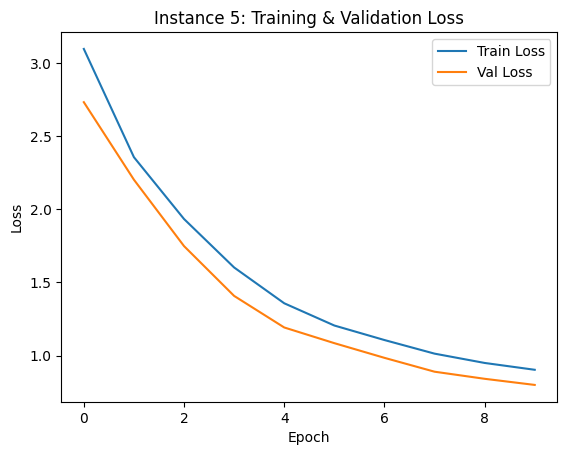

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━

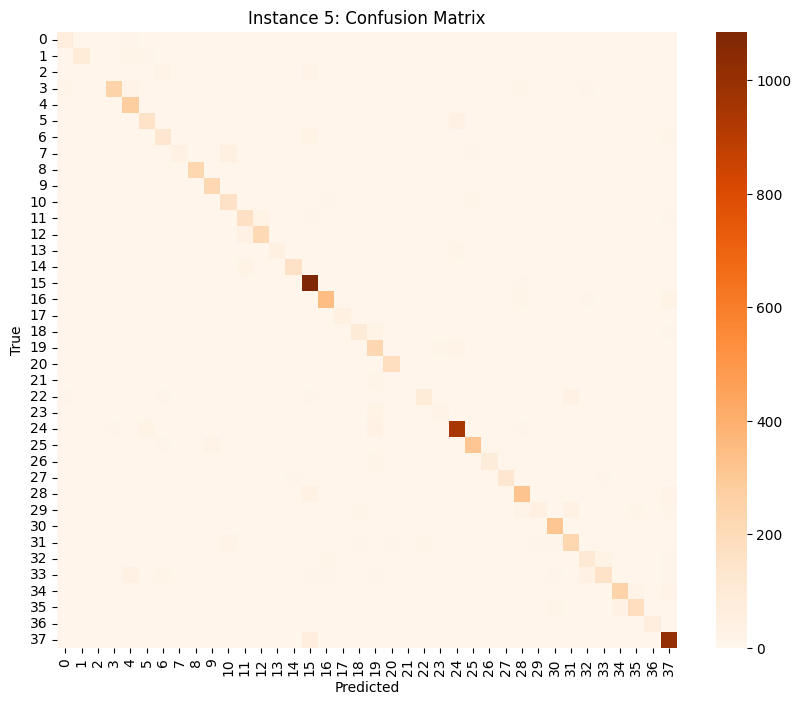

In [ ]:
# Plot loss curve
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Val Loss')
plt.title("Instance 5: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_5.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 5 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Oranges')
plt.title("Instance 5: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()